<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-20.-Attribute-Descriptors" data-toc-modified-id="Chapter-20.-Attribute-Descriptors-1">Chapter 20. Attribute Descriptors</a></span><ul class="toc-item"><li><span><a href="#Overriding-Versus-Nonoverriding-Descriptors" data-toc-modified-id="Overriding-Versus-Nonoverriding-Descriptors-1.1">Overriding Versus Nonoverriding Descriptors</a></span></li><li><span><a href="#Overriding-Descriptor-Without-__get__" data-toc-modified-id="Overriding-Descriptor-Without-__get__-1.2">Overriding Descriptor Without <code>__get__</code></a></span></li><li><span><a href="#Nonoverriding-Descriptor" data-toc-modified-id="Nonoverriding-Descriptor-1.3">Nonoverriding Descriptor</a></span></li><li><span><a href="#Overwriting-a-Descriptor-in-the-Class" data-toc-modified-id="Overwriting-a-Descriptor-in-the-Class-1.4">Overwriting a Descriptor in the Class</a></span></li><li><span><a href="#Methods-Are-Descriptors" data-toc-modified-id="Methods-Are-Descriptors-1.5">Methods Are Descriptors</a></span></li><li><span><a href="#Descriptor-Usage-Tips" data-toc-modified-id="Descriptor-Usage-Tips-1.6">Descriptor Usage Tips</a></span></li></ul></li></ul></div>

# Chapter 20. Attribute Descriptors

A class implementing a `__get__`, a `__set__`, or a `__delete__` method is a descriptor.

To summarize, the property factory pattern is simpler in some regards, but the descriptor class approach is more extensible. It’s also more widely used.

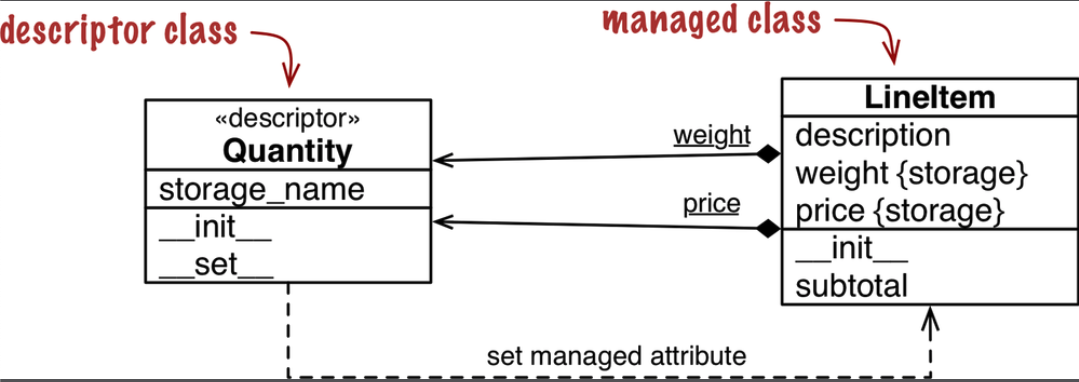

In [83]:
from IPython.display import Image
Image(filename = "descriptor.png")

In [84]:
class Quantity:   

    def __init__(self, storage_name):
        self.storage_name = storage_name   # self is the descriptor instance

    def __set__(self, instance, value):  # instance is the managed instance 
        if value > 0:
        # Descriptors managing instance attributes should store values 
        # in the managed instances.
            instance.__dict__[self.storage_name] = value   
        else:
            raise ValueError('value must be > 0')


class LineItem:
    # class attributes 
    # similar to static in C++
    # (shared among instances)
    weight = Quantity('weight')  
    price = Quantity('price')   

    def __init__(self, description, weight, price):   
        self.description = description # instance attributes 
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price


In [94]:
# prevent the sale of truffles for $0
truffle = LineItem('White truffle', 100, 0)

ValueError: value must be > 0

avoid repeating names in instance attribite ctor

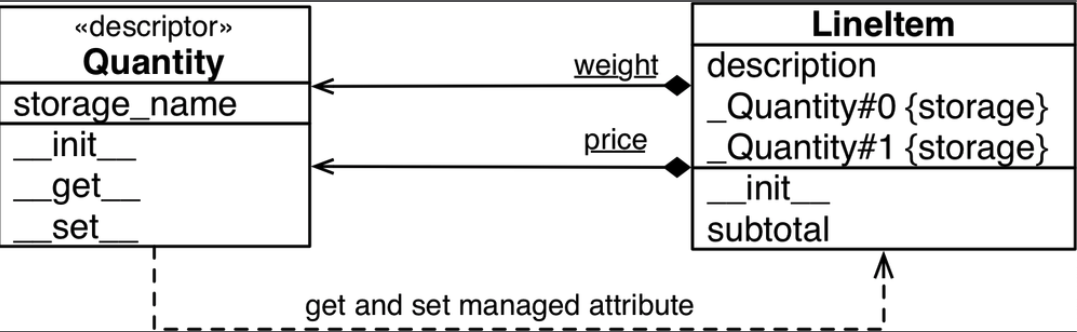

In [96]:
from IPython.display import Image
Image(filename = "descriptor2.png")

In [126]:
class Quantity:
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self   
        else:
            return getattr(instance, self.storage_name)   

    def __set__(self, instance, value):
        if value > 0:
            setattr(instance, self.storage_name, value)
        else:
            raise ValueError('value must be > 0')


class LineItem:
    weight = Quantity()   # avoid repeating names in instance attribite ctor
    price = Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

In [127]:
coconuts = LineItem('Brazilian coconut', 20, 17.95)
coconuts.weight, coconuts.price

(20, 17.95)

In [128]:
getattr(coconuts, '_Quantity#0'), getattr(coconuts, '_Quantity#1')

(20, 17.95)

In [129]:
vars(coconuts)

{'description': 'Brazilian coconut', '_Quantity#0': 20, '_Quantity#1': 17.95}

In [130]:
LineItem.weight

Refactor descriptor to allow validation on description attribute

In [142]:
import abc

class AutoStorage:   
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self
        else:
            return getattr(instance, self.storage_name)

    def __set__(self, instance, value):
        setattr(instance, self.storage_name, value)   


class Validated(abc.ABC, AutoStorage):   

    def __set__(self, instance, value):
        value = self.validate(instance, value)   
        super().__set__(instance, value)   

    @abc.abstractmethod
    def validate(self, instance, value):   
        """return validated value or raise ValueError"""


class Quantity(Validated):   
    """a number greater than zero"""

    def validate(self, instance, value):
        if value <= 0:
            raise ValueError('value must be > 0')
        return value


class NonBlank(Validated):
    """a string with at least one non-space character"""

    def validate(self, instance, value):
        value = value.strip()
        if len(value) == 0:
            raise ValueError('value cannot be empty or blank')
        return value   


In [138]:
class LineItem:
    description = NonBlank()   # enable validation on description
    weight = Quantity()
    price = Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price


In [141]:
br_nuts = LineItem('', 10, 34.95)

ValueError: value cannot be empty or blank

## Overriding Versus Nonoverriding Descriptors
A descriptor that implements the `__set__` method is called an overriding descriptor, because although it is a class attribute, a descriptor implementing `__set__` will override attempts to assign to instance attributes. 

Python contributors and authors use different terms when discussing these concepts. Overriding descriptors are also called data descriptors or enforced descriptors. Nonoverriding descriptors are also known as nondata descriptors or shadowable descriptors.

In [143]:
def cls_name(obj_or_cls):
    cls = type(obj_or_cls)
    if cls is type:
        cls = obj_or_cls
    return cls.__name__.split('.')[-1]

def display(obj):
    cls = type(obj)
    if cls is type:
        return '<class {}>'.format(obj.__name__)
    elif cls in [type(None), int]:
        return repr(obj)
    else:
        return '<{} object>'.format(cls_name(obj))

def print_args(name, *args):
    pseudo_args = ', '.join(display(x) for x in args)
    print('-> {}.__{}__({})'.format(cls_name(args[0]), name, pseudo_args))


### essential classes for this example ###

class Overriding:   
    """a.k.a. data descriptor or enforced descriptor"""

    def __get__(self, instance, owner):
        print_args('get', self, instance, owner)   

    def __set__(self, instance, value):
        print_args('set', self, instance, value)


class OverridingNoGet:   
    """an overriding descriptor without ``__get__``"""

    def __set__(self, instance, value):
        print_args('set', self, instance, value)


class NonOverriding:   
    """a.k.a. non-data or shadowable descriptor"""

    def __get__(self, instance, owner):
        print_args('get', self, instance, owner)


class Managed:   
    over = Overriding()
    over_no_get = OverridingNoGet()
    non_over = NonOverriding()

    def spam(self):   
        print('-> Managed.spam({})'.format(display(self)))


In [151]:
# obj.over triggers the descriptor get method, 
# passing the managed instance obj as the second argument.
obj = Managed()
obj.over

-> Overriding.__get__(<Overriding object>, <Managed object>, <class Managed>)


In [153]:
# Managed.over triggers the descriptor get method, 
# passing None as the second argument (instance).
Managed.over

-> Overriding.__get__(<Overriding object>, None, <class Managed>)


In [155]:
# Assigning to obj.over triggers the descriptor set method, 
# passing the value 7 as the last argument.
obj.over = 7

-> Overriding.__set__(<Overriding object>, <Managed object>, 7)


In [156]:
# Reading obj.over still invokes the descriptor get method.
obj.over

-> Overriding.__get__(<Overriding object>, <Managed object>, <class Managed>)


In [149]:
# Bypassing the descriptor, setting a value directly to the obj.dict.
obj.__dict__['over'] = 8
vars(obj)

{'over': 8}

In [158]:
# However, even with an instance attribute named over, 
# the Managed.over descriptor still overrides attempts to read obj.over.
obj.over

-> Overriding.__get__(<Overriding object>, <Managed object>, <class Managed>)


## Overriding Descriptor Without `__get__`
In this case, only writing is handled by the descriptor. Reading the descriptor through an instance will return the descriptor object itself because there is no `__get__` to handle that access.

In [167]:
# This overriding descriptor doesn’t have a `__get__` method, 
# so reading obj.over_no_get retrieves the descriptor instance 
# from the class.
obj.over_no_get

9

In [168]:
# The same thing happens if we retrieve the descriptor instance 
# directly from the managed class.
Managed.over_no_get

In [171]:
# Trying to set a value to obj.over_no_get invokes the 
# __set__ descriptor method
obj.over_no_get = 7

-> OverridingNoGet.__set__(<OverridingNoGet object>, <Managed object>, 7)


In [172]:
# Because our __set__ doesn’t make changes, reading obj.over_no_get 
# again retrieves the descriptor instance from the managed class.
obj.over_no_get

9

In [173]:
# Going through the instance __dict__ to set an instance attribute 
# named over_no_get.
# Now that over_no_get instance attribute shadows the descriptor, 
# but only for reading.
obj.__dict__['over_no_get'] = 9
obj.over_no_get

9

In [174]:
# Trying to assign a value to obj.over_no_get still goes through 
# the descriptor set.
obj.over_no_get = 7

-> OverridingNoGet.__set__(<OverridingNoGet object>, <Managed object>, 7)


In [175]:
# But for reading, that descriptor is shadowed as long as 
# there is a namesake instance attribute.
obj.over_no_get 

9

## Nonoverriding Descriptor
If a descriptor does not implement `__set__`, then it’s a nonoverriding descriptor. Setting an instance attribute with the same name will shadow the descriptor, rendering it ineffective for handling that attribute in that specific instance. 

In [192]:
# obj.non_over triggers the descriptor __get__ method, passing obj 
# as the second argument.
obj = Managed()
obj.non_over

-> NonOverriding.__get__(<NonOverriding object>, <Managed object>, <class Managed>)


In [193]:
# Managed.non_over is a nonoverriding descriptor, so there is 
# no __set__ to interfere with this assignment.
# The obj now has an instance attribute named non_over, 
# which shadows the namesake descriptor attribute in the Managed class.
obj.non_over = 7
obj.non_over

7

In [194]:
# The Managed.non_over descriptor is still there, and catches this 
# access via the class.
Managed.non_over

-> NonOverriding.__get__(<NonOverriding object>, None, <class Managed>)


In [195]:
# If the non_over instance attribute is deleted Then reading obj.non_over 
# hits the __get__ method of the descriptor in the class, 
# but note that the second argument is the managed instance.
del obj.non_over
obj.non_over

-> NonOverriding.__get__(<NonOverriding object>, <Managed object>, <class Managed>)


## Overwriting a Descriptor in the Class

Regardless of whether a descriptor is overriding or not, it can be overwritten by assignment to the class. This is a monkey-patching technique, which would effectively break any class that depended on the descriptors for proper operation.

In [197]:
obj = Managed()
Managed.over = 1   
Managed.over_no_get = 2
Managed.non_over = 3
obj.over, obj.over_no_get, obj.non_over 


(1, 2, 3)

## Methods Are Descriptors
all user-defined functions have a `__get__` method, therefore they operate as descriptors when attached to a class.

Because functions do not implement `__set__`, they are nonoverriding descriptors

In [198]:
obj = Managed()
obj.spam

<bound method Managed.spam of <__main__.Managed object at 0x7f9fb0d91af0>>

In [200]:
obj.spam = 7
obj.spam

7

In [202]:
import collections


class Text(collections.UserString):

    def __repr__(self):
        return 'Text({!r})'.format(self.data)

    def reverse(self):
        return self[::-1]


In [203]:
word = Text('forward')
word   

Text('forward')

In [204]:
word.reverse()   

Text('drawrof')

In [205]:
Text.reverse(Text('backward')) 

Text('drawkcab')

In [206]:
type(Text.reverse), type(word.reverse) 

(function, method)

In [207]:
list(map(Text.reverse, ['repaid', (10, 20, 30), Text('stressed')]))   

['diaper', (30, 20, 10), Text('desserts')]

In [209]:
Text.reverse.__get__(word) 

<bound method Text.reverse of Text('forward')>

In [210]:
Text.reverse.__get__(None, Text) 

<function __main__.Text.reverse(self)>

In [211]:
word.reverse   

<bound method Text.reverse of Text('forward')>

In [213]:
word.reverse.__self__ 

Text('forward')

In [214]:
word.reverse.__func__ is Text.reverse

True

## Descriptor Usage Tips
* Use property to Keep It Simple
* Read-only descriptors require `__set__`
* Validation descriptors can work with `__set__` only
* Caching can be done efficiently with `__get__` only
* Nonspecial methods can be shadowed by instance attributes